In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

2024-04-28 23:50:28.968079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 23:50:28.968516: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:50:28.970967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:50:29.000998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 23:50:29.556213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Set Environment Variables
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
# Time is irrelevant
df2 = df.drop(['Time'], axis=1)
# Standardize Amount
#df2['Amount'] = StandardScaler().fit_transform(df2['Amount'].values.reshape(-1, 1))
# split data
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [5]:
# check standardization of the data
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

[-1.60878544e-17  6.59133450e-18 -4.43587441e-18 -2.51470345e-18
 -2.24917576e-18 -6.18523333e-18 -6.71628871e-18 -5.46674663e-19
  1.46508810e-17 -1.52131749e-17  2.46159791e-17 -6.31018754e-18
 -7.65344528e-18 -9.68395117e-18 -1.84619843e-17  1.12458788e-18
  2.30852900e-17  1.05586306e-17 -7.99706935e-18  1.32763847e-18
  3.56119495e-18 -3.69864458e-17 -1.62440471e-18 -3.43936459e-17
  1.62440471e-17 -1.19643655e-17  1.24954209e-18 -2.24917576e-18
  4.37339730e-17]
[0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978]
[-9.64158338e-03  6.78752177e-03 -3.24662393e-03 -3.59966298e-03
  2.35552828e-03 -1.54444756e-03 -8.79391841e-03 -9.22211456e-04
 -7.35124705e-03 -1.33556197e-02  1.48988153e-02  9.97076818e-04
  3.49648368e-03 -9.50247775e-03  6.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

In [7]:
# defining the key parameters
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 50
epsilon_std = 1.0
K.square(10)

<tf.Tensor: shape=(), dtype=int32, numpy=100>

In [8]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
#########################
# input to our encoder
#########################
x = Input(shape=(original_dim,), name="input")
# intermediate layer
#h1 = Dense(intermediate_dim1, activation='tanh', name="encoding1")(x)
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 29)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding1 (Dense)   │ (None, 20)        │        600 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding (Dense)    │ (None, 10)        │        210 │ encoding1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 5)         │         55 │ encoding[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log-variance        │ (None, 5)         │         55 │ encoding[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5)         │          0 │ mean[0][0],       │
│                     │                   │            │ log-variance[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 920 (3.59 KB)

 Trainable params: 920 (3.59 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#########################
# Input to the decoder
#########################
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h2 (Dense)              │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h (Dense)               │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_decoded (Dense)            │ (None, 29)             │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
##########################
# Variational Autoencoder
##########################
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()
# Defina VAE Loss Function
def vae_loss_(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #vae_loss = K.mean(xent_loss + kl_loss)
    return xent_loss

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 5), (None, 5), │           920 │
│                                 │ (None, 5)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 29)             │           889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,809 (7.07 KB)

 Trainable params: 1,809 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
     
# Compile VAE model with custom loss function
vae.compile(optimizer='adam', loss=vae_loss_, metrics=['accuracy'])

# Train the model
history = vae.fit(X_train, X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(X_test, X_test),
                  verbose=1).history


Epoch 1/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 3s 988us/step - accuracy: 0.0380 - loss: -3.6974 - val_accuracy: 0.0308 - val_loss: -12.4423
Epoch 2/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.0337 - loss: -14.1546 - val_accuracy: 0.0540 - val_loss: -21.1569
Epoch 3/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - accuracy: 0.0525 - loss: -20.6878 - val_accuracy: 0.0702 - val_loss: -25.7042
Epoch 4/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 876us/step - accuracy: 0.0680 - loss: -26.2409 - val_accuracy: 0.0746 - val_loss: -30.8628
Epoch 5/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - accuracy: 0.0745 - loss: -30.7853 - val_accuracy: 0.0848 - val_loss: -34.6557
Epoch 6/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.0894 - loss: -35.0126 - val_accuracy: 0.0782 - val_loss: -37.0645
Epoch 7/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.0811 - loss: -36.3144 - val_accuracy: 0.0924 - val_loss: -40.9772
Epoch 8/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 916u

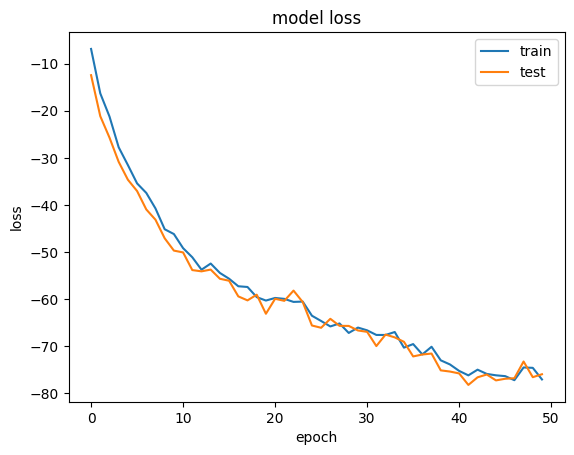

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [14]:

##########################################
# prediction & reconstruction error
##########################################
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df[(error_df['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df[(error_df['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step
Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               1.025426      0.001826
std                4.086562      0.042690
min                0.107062      0.000000
25%                0.437547      0.000000
50%                0.624381      0.000000
75%                0.904552      0.000000
max              460.725122      1.000000
Normal Sample        reconstruction_error  true_class
count          56858.000000     56858.0
mean               0.980860         0.0
std                3.729129         0.0
min                0.107062         0.0
25%                0.437173         0.0
50%                0.623806         0.0
75%                0.901963         0.0
max              460.725122         0.0
Fraud Sample        reconstruction_error  true_class
count            104.000000       104.0
mean              25.390048         1.0
std               30.958912         0.0
min               

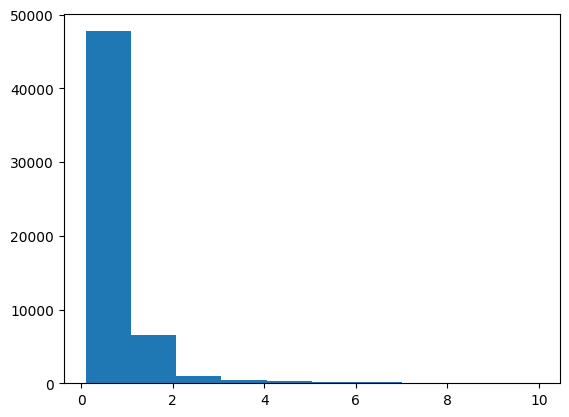

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

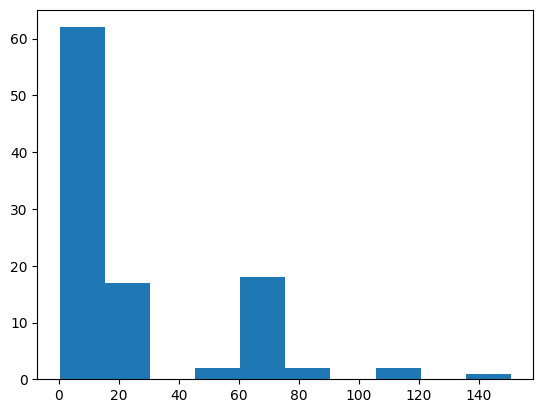

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [17]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

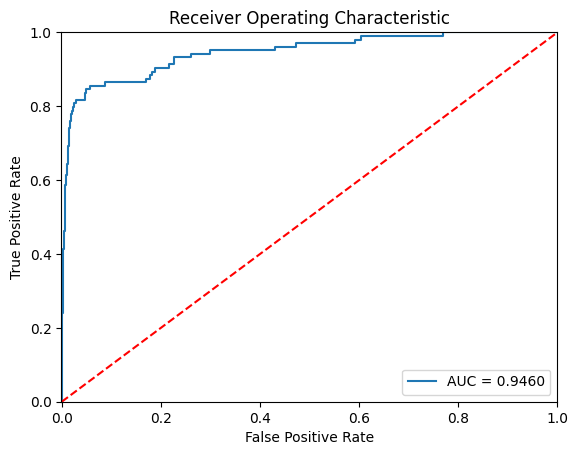

In [18]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

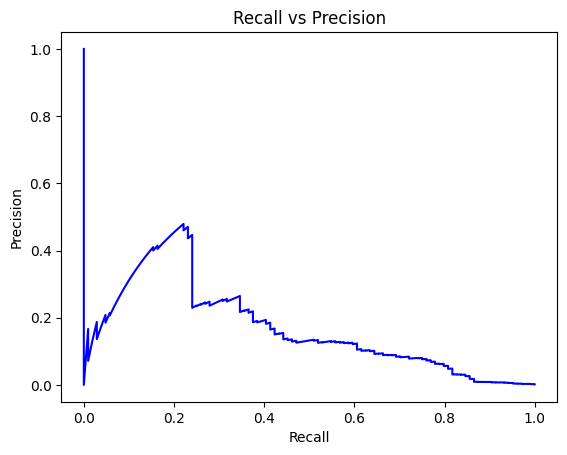

In [19]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

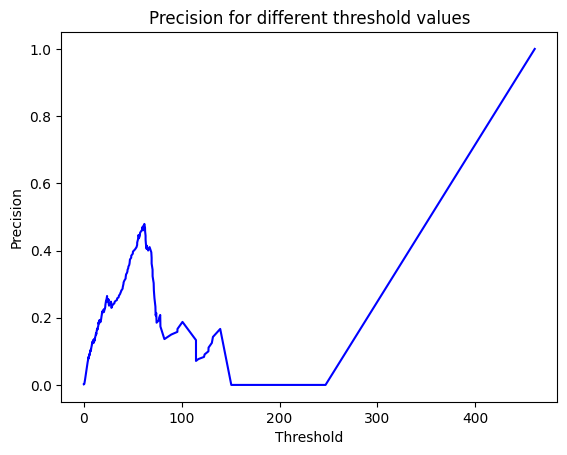

In [20]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

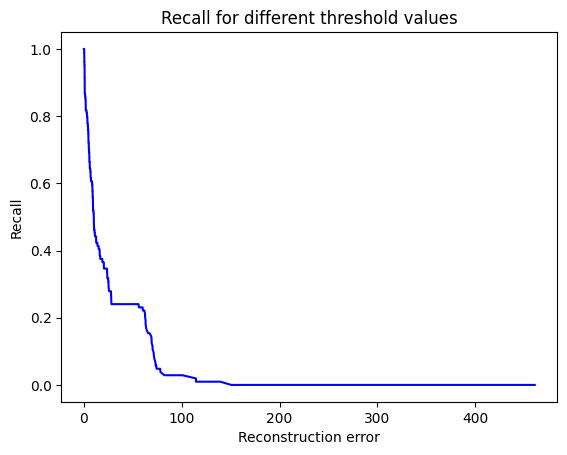

In [21]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

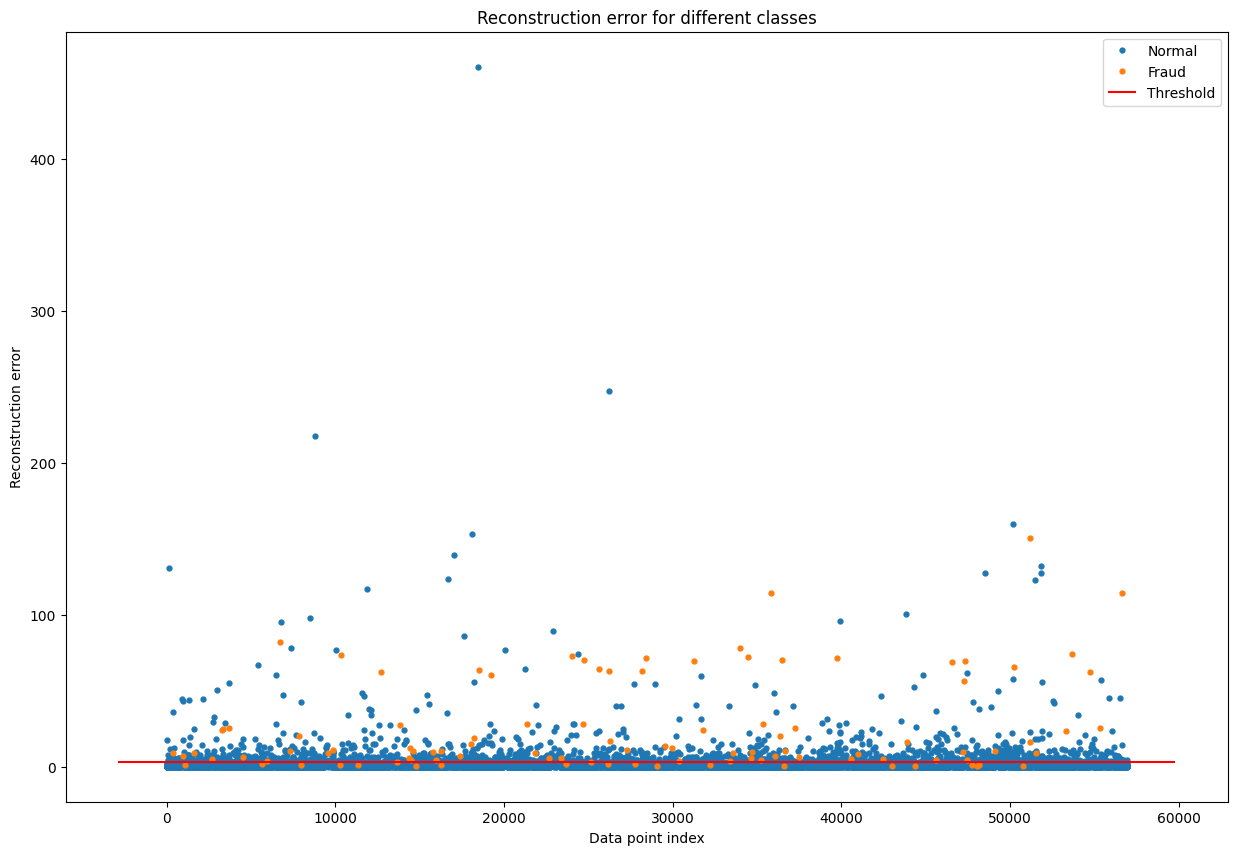

In [22]:

# scatter plot
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

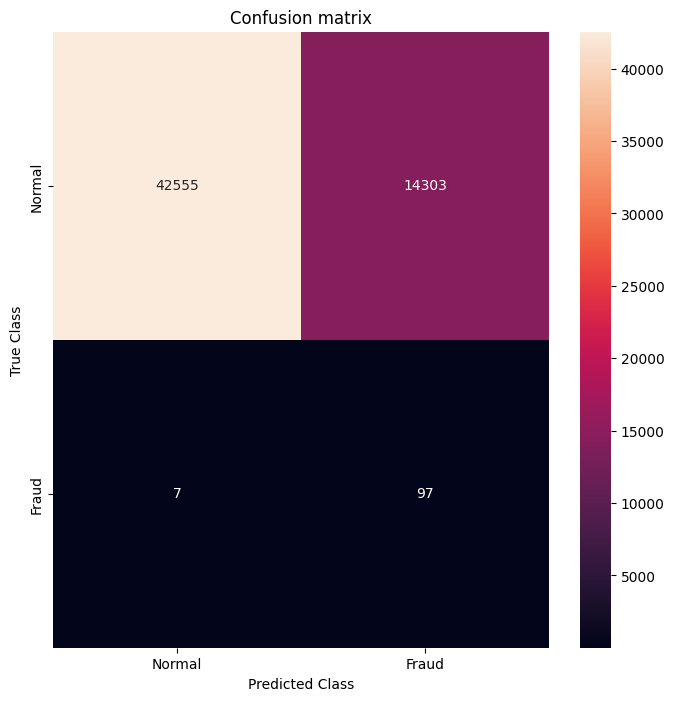

In [23]:
# confusion matrix
threshold = 0.9
# And see how well we're dividing the two types of transactions:
groups = error_df.groupby('true_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

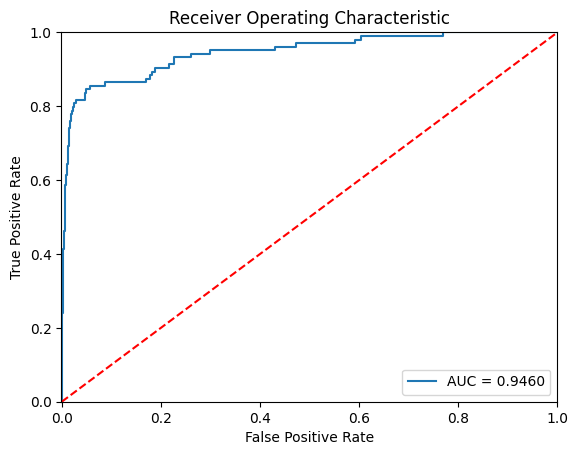

In [24]:

# ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
     